In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cPickle

import torch
import torch.nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models


In [2]:
%matplotlib inline
from itertools import product
import torchvision.transforms as transforms
from PIL import Image
from torch.autograd import Variable
import os
from torchvision.datasets import ImageFolder, DatasetFolder
import torch.utils.data

# SKIP

In [3]:
##SKIP
cifar_path = '/Users/akshay/proj/cifar-10-py'
imagenet_path = '/Users/akshay/proj/imagenet'

# First load meta data
filename = 'batches.meta'
with open(cifar_path + '/' + filename, 'rb') as fo:
    metadata = cPickle.load(fo)

# Then load one batch
filename = 'data_batch_1'
with open(cifar_path + '/' + filename, 'rb') as fo:
    data_1 = cPickle.load(fo)


data_1['labels'] = np.array(data_1['labels'])

In [5]:
##SKIP
def extract_images(inds , data=data_1['data'], imsz=32):
    # Reshape into 10000 x 3 x 32 x 32
    images = np.moveaxis(np.reshape(data, (data.shape[0], 3, imsz, imsz)), 1, 3)
    return images[inds,:,:,:]

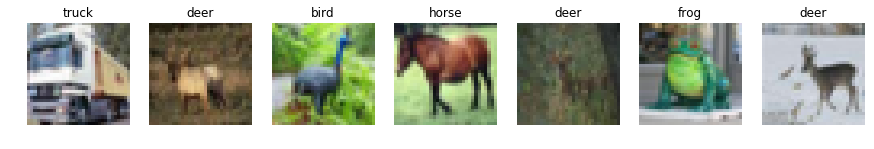

In [92]:
inds = [1,3,6,7,10, 19, 20]
images = extract_images(inds)

fig = plt.figure(figsize=(15,5))

for i in range(len(inds)):
    ax = plt.subplot(1,len(inds),i+1)
    
    plt.imshow(np.squeeze(images[i,:,:,:]))
    plt.title(metadata['label_names'][data_1['labels'][inds[i]]])
    plt.axis('off')

In [451]:
## Generate Stimuli

savedir = '/Users/akshay/proj/psych209/attention/stimuli'

def generate_stimuli(nObjectsPerImg=4, savedir=savedir, nStims=100, imsz=96):
    all_locs = np.array(list(product(np.arange(imsz/32)*32, np.arange(imsz/32)*32)))

    meta5 = dict()
    for j in range(nStims):
        background = np.zeros((imsz,imsz,3),dtype=np.uint8) + 128 # grayscale background
        loc_ind = np.random.choice(len(all_locs), size=(nObjectsPerImg,), replace=False)

        meta5[j+1] = dict()

        # Randomly select N objects per image, and extract them from the pickle.
        img_ind = []
        for i in range(nObjectsPerImg):
            label_inds = np.nonzero(data_1['labels']==i)[0]
            img_ind.append(np.random.choice(label_inds,1)[0])
        img_ind = np.array(img_ind)
        images = extract_images(img_ind)

    #     # randomly set half the pixels to noisy
    #     for _ in range(256**2 / 2.0):
    #         background[np.random.randint(background.shape[0]), np.random.randint(background.shape[1]), :] = 

        for i in range(nObjectsPerImg):
            loc = all_locs[loc_ind[i],:]
            background[loc[0]:loc[0]+32, loc[1]:loc[1]+32, :] = np.squeeze(images[i,:,:,:])

            # Save the location of each object as a key-value pair in the meta dictionary.
            meta5[j+1][metadata['label_names'][data_1['labels'][img_ind[i]]]] = loc

        # Save image as png.
        savename = 'stim{0}_{1:03d}'.format(nObjectsPerImg, j+1)
        plt.imsave(savedir + '/' + savename + '.png', background)
        
    np.save(savedir + '/meta{0}'.format(nObjectsPerImg), meta5)
    return meta5

meta5 = generate_stimuli(imsz=64)

## Generate Stimuli For Imagenet Experiment

In [24]:
## Generate Stimuli

#savedir = '/Users/akshay/proj/psych209/attention/imagenet_stimuli'
imagenet_path = '/scratch/groups/jlg/imagenet'
savedir = '/home/users/akshayj/att_net/attention/imagenet_test_stimuli'
if not os.path.exists(savedir):
    os.makedirs(savedir)

labels = ['elephant', 'leopard', 'truck', 'plane']

def generate_stimuli(nObjectsPerImg=4, savedir=savedir, nStims=100, imsz=256):
    all_locs = np.array(list(product(np.arange(imsz/128)*128, np.arange(imsz/128)*128)))

    meta5 = dict()
    for j in range(nStims):
        background = np.zeros((imsz,imsz,3),dtype=np.uint8) + 128 # grayscale background
        loc_ind = np.random.choice(len(all_locs), size=(nObjectsPerImg,), replace=False)

        meta5[j+1] = dict()

        # Randomly select N objects per image, and extract them from the pickle.
        img_ind = []
        lbls = np.random.permutation(labels)
        for i in range(nObjectsPerImg):
            
            cat1 = os.listdir(imagenet_path +'/'+lbls[i])
            img_ind.append(lbls[i]+'/'+np.random.choice(cat1))
            img = np.array(Image.open(imagenet_path+'/'+img_ind[-1]).resize((128,128)))
            
            if len(img.shape) < 3:
                img = np.stack((img,)*3, axis=-1)

            loc = all_locs[loc_ind[i],:]
            background[loc[0]:loc[0]+128, loc[1]:loc[1]+128, :] = img

            # Save the location of each object as a key-value pair in the meta dictionary.
            meta5[j+1][lbls[i]] = i

        # Save image as png.
        savename = 'stim{0}_{1:03d}'.format(nObjectsPerImg, j+1)
        savepath = savedir + '/' + savename + '.png'
        
        for i in range(nObjectsPerImg):
            catg = lbls[i]
            loca = np.where(lbls==labels[i])[0][0]
            loca = loc_ind[i]
            new_savedir = '{}/{}_{}'.format(savedir, catg, loca)
            if not os.path.exists(new_savedir):
                os.makedirs(new_savedir)

            # Copy the file into the appropriate folder.
            plt.imsave('{}/{}.png'.format(new_savedir, savename), background)
        
    np.save(savedir + '/meta{0}'.format(nObjectsPerImg), meta5)
    return meta5

meta5 = generate_stimuli(nStims=1000)

/share/software/user/open/py-pillow/5.1.0_py27/lib/python2.7/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/share/software/user/open/py-pillow/5.1.0_py27/lib/python2.7/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 395876289 bytes but only got 0. Skipping tag 34464
  " Skipping tag %s" % (size, len(data), tag))


## Real Code Starts Here

In [3]:
vgg19 = models.vgg19(pretrained=True)
for param in vgg19.parameters():
    param.requires_grad = False

with open('imagenet1000.txt') as f:
    num2label = eval(f.read())

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
imsize = 240
loader = transforms.Compose([transforms.Scale(imsize), transforms.CenterCrop(imsize), transforms.ToTensor(), normalize])
def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name).convert('RGB')

    image = loader(image).float()
    image = Variable(image, requires_grad=False)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image#.to_device(device)  #assumes that you're using GPU


/share/software/user/open/py-pytorch/1.0.0_py27/lib/python2.7/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [5]:
def print_predictions(output, num2label=num2label, numlines=3):
    for idx in output[0].sort(descending=True)[1][:numlines].numpy():
        print num2label[idx], output[0][idx].detach().item() 

In [6]:
class AttVGG(torch.nn.Module):
    def __init__(self, whichQuadrant):
        super(AttVGG, self).__init__()
        self.vgg19 = models.vgg19()
        self.conv1 = torch.nn.Sequential(*list(vgg19.children())[0][:2])
        self.convRest = torch.nn.Sequential(*list(vgg19.children())[0][2:])
        self.FCs = torch.nn.Sequential(*list(vgg19.children())[1])
        self.whichQuadrant = whichQuadrant
        
    def forward(self, image):
        a = self.conv1(image)
        
        b = torch.ones(a.shape)
        if self.whichQuadrant == 1: # top left
            b[:,:,:b.shape[2]/2,:b.shape[2]/2] = 10
        elif self.whichQuadrant ==2: # top right
            b[:,:,:b.shape[2]/2,b.shape[2]/2:] = 10
        elif self.whichQuadrant == 3: # bottom left
            b[:,:,b.shape[2]/2:,:b.shape[2]/2] = 10
        else: # bottom right
            b[:,:,b.shape[2]/2:, b.shape[2]/2:] = 10

        a2 = self.convRest(a*b)
        a2 = a2.view(a2.size(0),-1)
        output = self.FCs(a2)
        return output

In [7]:
class AttRNN(torch.nn.Module):
    def __init__(self, hidden_size=4, num_rnn_layers=10):
        super(AttRNN, self).__init__()
        self.hidden_size = hidden_size
        
        vgg19 = models.vgg19(pretrained=True)
        self.earlyLayers = torch.nn.Sequential(*list(vgg19.children())[0][:28])
        self.layer1 = torch.nn.Sequential(*list(vgg19.children())[0][:28])
        for param in self.earlyLayers.parameters():
            param.requires_grad = False

        self.rnn = torch.nn.LSTM(115200, self.hidden_size, num_rnn_layers, dropout=.05)
        self.out = torch.nn.Linear(hidden_size, 1)

    def forward(self, inputs, hidden=None):
        inp_ = self.earlyLayers(inputs)
        # Unravel the earlyLayers output before sending into the RNN
        inp_ = inp_.view(inp_.size(0),-1).unsqueeze(0)
        
        output, hidden = self.rnn(inp_, hidden)
        output = self.out(output.squeeze(1))
        return output, hidden

## Training

In [8]:
device

device(type='cuda')

In [ ]:
n_epochs = 50
n_iters = 50
hidden_size = 4
num_rnn_layers = 10
batch_size = 50

stimdir = '/home/users/akshayj/att_net/attention/imagenet_stimuli/'
train_dataset = ImageFolder(stimdir, loader=image_loader)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model = AttRNN(hidden_size)
model.cuda()
loss_func = torch.nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

train_losses = np.zeros(n_epochs) # For plotting

# Test accuracies
all_test_true = [];
all_test_pred = []
all_test_losses = [];
for epoch in range(n_epochs):
    test_true = []; test_pred = []; test_losses = [] 

    for step, (x,y) in enumerate(train_data_loader):
        b_x = Variable(torch.squeeze(x)).cuda()
        b_y = Variable(torch.fmod(y,4)).type(torch.float32).cuda() # labels
        
        hid = torch.div(y,4).unsqueeze(1);
        one_hot = torch.FloatTensor(hid.shape[0], 4).zero_()
        one_hot.scatter_(1, hid, 1)

        h0 = Variable(torch.stack((one_hot,)*num_rnn_layers, dim=0)).cuda()
        c0 = Variable(torch.randn(num_rnn_layers, batch_size, hidden_size)).cuda()

                 
        # Get training loss.
        output, (hn, cn) = model(b_x, (h0,c0))
        loss = loss_func(output,b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses[epoch] += loss.item()
        
        if step % 10 == 0:
            print 'Step {}: Training Loss = {}; Test Loss = {}'.format(step, loss.item(), test_losses[-1])

    with torch.no_grad():
        all_test_true.append(test_true)
        all_test_losses.append(test_losses)
        all_test_pred.append(test_pred)
    if epoch > 0:
        print '---Epoch {}---'.format(epoch)

Step 0: Training Loss = 4.35145139694; Test Loss = 4.34992218018
Step 10: Training Loss = 4.00251150131; Test Loss = 4.00443792343
Step 20: Training Loss = 1.80099487305; Test Loss = 1.79871797562
Step 30: Training Loss = 1.82044553757; Test Loss = 1.82019615173
Step 40: Training Loss = 1.93800902367; Test Loss = 1.93839216232
Step 50: Training Loss = 1.69682621956; Test Loss = 1.69526326656
Step 60: Training Loss = 1.63450312614; Test Loss = 1.63329005241
Step 70: Training Loss = 1.45815062523; Test Loss = 1.45787155628
Step 0: Training Loss = 1.38417124748; Test Loss = 1.3846642971
Step 10: Training Loss = 1.37658452988; Test Loss = 1.37759160995
Step 20: Training Loss = 1.32943344116; Test Loss = 1.33104848862
Step 30: Training Loss = 1.21643614769; Test Loss = 1.21636843681
Step 40: Training Loss = 1.00453257561; Test Loss = 1.00413048267
Step 50: Training Loss = 1.37540614605; Test Loss = 1.37495088577
Step 60: Training Loss = 1.44154858589; Test Loss = 1.44193673134
Step 70: Trai

In [27]:
atl = np.array(all_test_losses)
atp = np.squeeze(np.array(all_test_pred))
att = np.squeeze(np.array(all_test_true))

print np.sum(atl,axis=1).shape, atp.shape, att.shape

(16,) (16, 80, 50) (16, 80, 50)


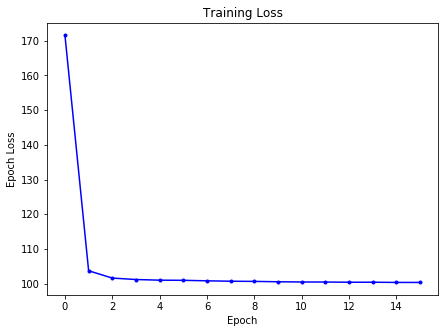

In [24]:
fig = plt.figure(figsize=(7,5))

plt.title('Training Loss')
plt.ylabel('Epoch Loss')
plt.xlabel('Epoch');
plt.plot(train_losses[:16], '.-b');
#plt.plot(np.sum(atl,axis=1), '.-g')

In [26]:
batch_size = 100

stimdir = '/home/users/akshayj/att_net/attention/imagenet_test_stimuli/'
test_dataset = ImageFolder(stimdir, loader=image_loader)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
test_true = []; test_pred = [];
test_losses = [] # For plotting

for step, (x,y) in enumerate(test_data_loader):
    with torch.no_grad():
        b_x = Variable(torch.squeeze(x)).cuda()
        b_y = Variable(torch.fmod(y,4)).type(torch.float32).cuda() # labels

        hid = torch.div(y,4).unsqueeze(1);
        one_hot = torch.FloatTensor(hid.shape[0], 4).zero_()
        one_hot.scatter_(1, hid, 1)

        h0 = Variable(torch.stack((one_hot,)*num_rnn_layers, dim=0)).cuda()
        c0 = Variable(torch.randn(num_rnn_layers, batch_size, hidden_size)).cuda()

        output, (hn, cn) = model(b_x, (h0,c0))
        loss = loss_func(output,b_y)
    
        test_losses.append(loss.item())
        test_true.append(b_y.cpu().numpy())
        test_pred.append(output.cpu().numpy())
        acc = np.corrcoef(b_y.cpu().numpy().ravel(),output.cpu().numpy().ravel())[0,1]
        if step % 5 == 0:
            print 'Step {} Test Loss = {}; R2 = {}'.format(step, test_losses[-1], acc)

Step 0 Test Loss = 1.31427025795; R2 = 0.0100631877273
Step 5 Test Loss = 1.35300302505; R2 = 0.00775310386192
Step 10 Test Loss = 1.39440000057; R2 = -0.090660325961
Step 15 Test Loss = 1.25195074081; R2 = 0.119076627506
Step 20 Test Loss = 1.05200564861; R2 = -0.151141522079
Step 25 Test Loss = 1.15349674225; R2 = -0.0425629048742
Step 30 Test Loss = 1.13309776783; R2 = -0.0150864686899
Step 35 Test Loss = 1.07194757462; R2 = -0.00938195162454


In [62]:
a = np.squeeze(np.array(test_pred))
b = np.array(test_true)
print a.shape, b.shape
print np.corrcoef(a.ravel(), b.ravel())

(40, 100) (40, 100)


array([[ 1.        , -0.01980104],
       [-0.01980104,  1.        ]])